## Install Packages

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import sklearn
import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, SequentialSampler
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from src.utils.triplet_loss import BatchAllTtripletLoss
from tqdm.notebook import tqdm
from src.utils.celeba_helper import CelebADataset, CelebAClassifier, CelebADatasetTriplet, get_embeddings_and_file_names
from src.utils.loss_functions import TripletLoss
from src.utils.similarity_functions import euclidean_distance_matrix
from importlib import reload

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
nGPU = torch.cuda.device_count()
print(device)

cuda:0


# Define CelebA Dataset and Loader

In [2]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba'
mapping_file = 'data/identity_CelebA.txt'

image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, mapping_file, transform)

### Define train and test dataset

In [3]:
train_img_pp = 2

train_files, train_labels = celeba_dataset.create_X_shot_dataset(img_pp=2)
print(f"TRAIN SET: There are {len(train_files)} images in the training data of {len(np.unique(train_labels))} people.")

TRAIN SET: There are 20266 images in the training data of 10133 people.


In [4]:
flm = celeba_dataset.file_label_mapping

flm.loc[:, 'is_train'] = 0
flm.loc[flm['file_name'].isin(train_files), 'is_train'] = 1
flm['file_id'] = [int(elem[:6])-1 for elem in flm['file_name'].values]

train_df = flm[flm['is_train']==1]
test_df = flm[flm['is_train']==0]

train_df.head(3)

,file_name,person_id,is_train,file_id
0,000001.jpg,2880,1,0
1,000002.jpg,2937,1,1
2,000003.jpg,8692,1,2


### Create DataLoaders

In [5]:
# Number of workers for the dataloader
num_workers = 12 * nGPU if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# Train set parameters
batch_size = 256

is_subset = False
size_train_set = 1000

# Test set parameters
test_batch_size = 256

# Sample datasets for faster experimentation
subset_people = np.unique(train_df['person_id'])
subset_train_df = pd.DataFrame.copy(train_df)
subset_test_df = pd.DataFrame.copy(test_df)

if is_subset:
    subset_people = np.random.choice(np.unique(train_df['person_id']), size=size_train_set, replace=False)
    subset_train_df = pd.DataFrame.copy(train_df[train_df['person_id'].isin(subset_people)])
    subset_test_df = pd.DataFrame.copy(test_df[test_df['person_id'].isin(subset_people)])

train_inds = subset_train_df['file_id'].values.tolist()
test_inds = subset_test_df['file_id'].values.tolist()

# Create dataloaders
train_loader = DataLoader(
    celeba_dataset,
    num_workers=num_workers,
    batch_size=batch_size,
    pin_memory=pin_memory,
    sampler=SubsetRandomSampler(train_inds)
)
    
test_loader = DataLoader(
    celeba_dataset,
    num_workers=num_workers,
    batch_size=test_batch_size,
    pin_memory=pin_memory,
    sampler=SubsetRandomSampler(test_inds)
)
test_set_num_people = len(np.unique(subset_test_df['person_id']))
                                                                   
print(f"TRAIN SET: There are {len(train_inds)} images of {len(np.unique(subset_train_df['person_id']))} people in the train set.")
print(f"TEST SET:  There are {len(test_inds)} images of {len(np.unique(subset_test_df['person_id']))} people in the test set.") 

TRAIN SET: There are 20266 images of 10133 people in the train set.
TEST SET:  There are 182333 images of 9853 people in the test set.


/opt/conda/envs/faceenv2/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# FaceNet Training Pipeline

## Initializing the resnet model, optimizer and loss function

In [6]:
margin = 0.5
gamma = 0.1
lr = 0.1
epochs = 200

schedule = [40, 80, 130, 160]
str_schedule = "_".join(map(str, schedule))

resnet = InceptionResnetV1(pretrained='vggface2', classify=False).to(device)

In [7]:
# @title Freeze upstream layers
def set_parameter_requires_grad(model):
    for name, param in model.named_parameters():
        if "last" not in name:
            param.requires_grad = False

set_parameter_requires_grad(resnet)
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

last_linear.weight
last_bn.weight
last_bn.bias


In [8]:
# @title Define optimizer and loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)
criterion = BatchAllTtripletLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=schedule, gamma=gamma)

## Training steps

In [11]:
def train_step(X, y, train_df):
    X, y = celeba_dataset.find_positive_observations(X, y, train_df)
        
    # Create embeddings
    X_emb = resnet(X.to(device))
    optimizer.zero_grad()

    loss = criterion(X_emb, y.to(device))
    loss.backward()
    optimizer.step()
    return loss

In [12]:
# Test train_step
X, y = next(iter(train_loader))
train_step(X, y, train_df)

tensor(0.3973, device='cuda:0', grad_fn=<DivBackward0>)

In [29]:
resnet.train()
epochs = 10
loss_total = []

for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
    running_loss = []
    for step, (X,y) in enumerate(tqdm(train_loader, desc='Current Batch', leave=True)):
        loss = train_step(X, y, train_df)
        running_loss.append(loss.cpu().detach().numpy())

    loss_total.append(np.mean(running_loss))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1/10 - Loss: 0.4258


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2/10 - Loss: 0.4124


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3/10 - Loss: 0.4070


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4/10 - Loss: 0.4054


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5/10 - Loss: 0.4018


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6/10 - Loss: 0.4011


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7/10 - Loss: 0.4014


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8/10 - Loss: 0.3975


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9/10 - Loss: 0.3994


Current Batch:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 10/10 - Loss: 0.3983


In [30]:
from datetime import datetime

now = datetime.now()
dt_str = now.strftime("%Y-%m-%d_%H:%M:%S")

# Save model weights
model_state_path = f"models/facenet_model_statedict_{dt_str}_{size_train_set}people_{train_img_pp}imgpp_{epochs}epochs.pth"
if not os.path.exists(model_state_path):
    torch.save(resnet.state_dict(), model_state_path)

# Save loss values
losses_path = f"experiments/loss_train_list_{dt_str}_{size_train_set}people_{train_img_pp}imgpp_{epochs}epochs.pth"
if not os.path.exists(model_state_path):
    torch.save(torch.FloatTensor(running_loss), losses_path)

## Plotting Loss curve

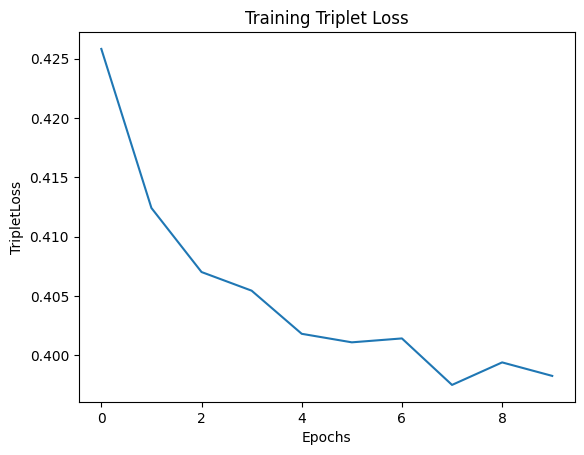

In [31]:
# printing loss function
plt.plot(loss_total)
plt.xlabel("Epochs")
plt.ylabel("TripletLoss")
plt.title("Training Triplet Loss")
plt.savefig(f"loss_curves/loss_curve_{dt_str}_{size_train_set}people_{train_img_pp}imgpp_{epochs}epochs_{lr}lr.png")
plt.show()

## Testing the trained model:

## Accuracy of the model

In [33]:
# Get embeddings - either from files (if exists) or by running model
from datetime import datetime

train_embeddings_path = f'pytorch_objects/train_embeddings_{dt_str}_{size_train_set}people_{train_img_pp}imgpp_{epochs}epochs.pt'
train_labels_path = f'pytorch_objects/train_labels_{dt_str}_{size_train_set}people_{train_img_pp}imgpp_{epochs}epochs.pt'
test_embeddings_path = f'pytorch_objects/test_embeddings_{dt_str}_{size_train_set}people_{epochs}epochs.pt'
test_labels_path = f'pytorch_objects/test_labels_{dt_str}_{size_train_set}people_{epochs}epochs.pt'

train_embeddings, train_labels = get_embeddings_and_file_names(resnet, train_loader, train_embeddings_path, train_labels_path)
test_embeddings, test_labels = get_embeddings_and_file_names(resnet, test_loader, test_embeddings_path, test_labels_path)
# aug_embeddings, aug_labels = celeba_helper.get_embeddings_and_file_names(resnet, aug_loader, save_tensors=False)
    
print(f'TRAIN:     Embeddings: {train_embeddings.shape}.\tLabels: {train_labels.shape}.')
# print(f'AUGMENTED: Embeddings: {aug_embeddings.shape}.\tLabels: {aug_labels.shape}.')
print(f'TEST:      Embeddings: {test_embeddings.shape}. Labels: {test_labels.shape}.')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

TRAIN:     Embeddings: torch.Size([20266, 512]).	Labels: torch.Size([20266]).
TEST:      Embeddings: torch.Size([182333, 512]). Labels: torch.Size([182333]).


In [34]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_embeddings, train_labels)
score = knn.score(test_embeddings, test_labels)

print(f'Pre-trained model: Accuracy = {score}.')

Pre-trained model: Accuracy = 0.48917639703180443.
CPU times: user 2min 30s, sys: 24.8 s, total: 2min 55s
Wall time: 1min 13s
